In [11]:
import pandas as pd
import numpy as np
import scipy as sp
import math
import Hull_White as hw
import mortgage as m
import Discount_Functions as disc_func
import itertools
import matplotlib.pyplot as plt
from __future__ import absolute_import, division, print_function
%matplotlib inline

In [12]:
cap_rate = 0.0475      # given in HW2_Data file
short_rate = 0.01816   # given in HW2_Data file
dt = 0.25

HW = hw.Hull_White()   #our Hull White class
K = 1/(1+cap_rate*dt)  #strike in put model

# from HW1 problem set
kappa = 0.153
sigma = 0.0153

# from HW1 REMIC data file
WACs = [0.05402, 0.05419]   # WAC values for two pools

In [13]:
df_stmat = pd.read_csv('stmat.csv')
df_tvmat = pd.read_csv('tvmat.csv')
df_disc_factors = pd.read_csv('discount factors.csv')
df_caplet_vols = pd.read_csv('caplet vols.csv')
df_mthly_10_yr_LIBOR_04 = pd.read_csv('monthly 10 year LIBOR spot rates for 2004.csv')

df_stmat['Coupon Gap'] = df_stmat['Coupon Gap'] * 0.0001 # convert from basis points to decimal
df_tvmat['Coupon Gap'] = df_tvmat['Coupon Gap'] * 0.0001 # convert from basis points to decimal

#### Forward rates from dicsount functions

In [14]:
## import and clean data
data_z = pd.read_csv("discount factors.csv", header = 0)

## fit Z curve using OLS
data_z["poly"] = np.log(data_z["Price"])
z_OLS = disc_func.OLS(disc_func.power_5(data_z["Maturity"]), data_z["poly"])
print("my estimation of coefficients are:")
print(z_OLS.beta)

(a,b,c,d,e) = z_OLS.beta
coeff = [a,b,c,d,e]

my estimation of coefficients are:
[ -2.32447481e-02  -3.81606103e-03   1.62964402e-04  -3.02679751e-06
   2.09422571e-08]


In [15]:
r0 = short_rate

#### Ouput results from matlab functions

In [16]:
gamma = 0.0568
p = 2.9025
beta_1 = -12.6051
beta_2 = -2.0992

#### Standard error results from matlab code

In [17]:
gamma_se = 0.0018
p_se = 0.0750
beta_1_se = 1.9998
beta_2_se = 0.0495

# Q(a)

#### hazard function

In [18]:
beta = np.array([beta_1, beta_2])

def libor_rate_10yr_lag3_from_MC(r_arr):
    libor_arr = [0.0539, 0.0522, 0.0510]
    t_range = np.arange(1,361-3-12*10)
    for t in t_range:
        r_1 = r_arr[t]
        r_10 = r_arr[t+12*10]
        libor_arr.append((r_10*(t+10*12) - r_1*(t)) / (t+10*12 - t))
    return libor_arr

# DO NOT USE THIS FUNCTION!!
def libor_rate_10yr_lag3(t):
    #here the time input t should be integer month
    if t==1:
        return 0.0539
    elif t==2:
        return 0.0522
    elif t==3:
        return 0.0510
    else:
        t = (t-3)/12
        r_10 = HW.r_t(0, t+10, r0, kappa, sigma, coeff)
        r_1 = HW.r_t(0, t, r0, kappa, sigma, coeff)
        return((r_10*(t+10) - r_1*(t)) / (t+10 - t))

def summer_index_func(t):
    # starting from Sept. plus 8
    t = t + 8
    return 1 if t%12 in [5,6,7,8] else 0

def hazard_func(t, gamma, p, beta, pool, libor_arr):
    #here the time input t should be integer month
    t = int(t)
    v = np.array([WACs[pool] - libor_arr[t-1], summer_index_func(t)])
    exp_val = np.dot(v, beta)
    return ((gamma*p * (gamma * t)**(p-1)) / (1 + (gamma * t)**p)) * np.exp(exp_val)

def hazard_func_arr(gamma, p, beta, pool, libor_arr):
    #here the time input t should be integer month
    t_range = np.arange(1,241)
    summer_index_arr = [summer_index_func(t) for t in t_range]
    v = np.array([WACs[pool] - libor_arr, summer_index_arr])
    v = np.transpose(v)
    exp_val = np.dot(v, beta)
    return ((gamma*p * (gamma * t_range)**(p-1)) / (1 + (gamma * t_range)**p)) * np.exp(exp_val) 

def SMM_func(tminus, tplus, gamma, p, beta, pool, libor_arr):
    int_res = sp.integrate.quad(lambda s: hazard_func(s, gamma, p, beta, pool, libor_arr), tminus, tplus)[0]
    return(1-np.exp(-int_res))

def SMM_func_arr(gamma, p, beta, pool, libor_arr):
    return (1-np.exp(-hazard_func_arr(gamma, p, beta, pool, libor_arr) * 1))


In [99]:
# 5,000 simulation, so that the total number of paths is 10,000
num_sims = 5
T = 20
dt = 1.0/12.0
dr = 10e-5  # dr taken to be arbitrarily small
## Simlation:
## cum_df_matrix = cumulative discount factor matrix
## cum_df_anti_matrix = cumulative discount factor matrix with antithetic path

## T=30 since we need to calculate 10yr libor rate (20+10=30)
(cum_df_matrix, cum_df_anti_matrix, r_matrix, r_anti_matrix) = HW.Monte_Carlo_2(kappa, sigma, r0, 30, dt, coeff, num_sims)

# we only need 240 period discount factor, using 360 to get short rate -> to get libor later
cum_df_matrix = cum_df_matrix[:,:240]
cum_df_anti_matrix = cum_df_anti_matrix[:,:240]

In [100]:
def get_libor_rate_matrix(r_matrix, num_sims):
    libor_rate_matrix = []
    libor_rate_matrix_anti = []
    for i in range(num_sims):
        libor_rate_matrix.append(libor_rate_10yr_lag3_from_MC(r_matrix[i,:]))
        libor_rate_matrix_anti.append(libor_rate_10yr_lag3_from_MC(r_anti_matrix[i,:]))
    #libor_rate_matrix = 0.5 * (np.matrix(libor_rate_matrix) + np.matrix(libor_rate_matrix_anti))
    libor_rate_matrix = np.matrix(libor_rate_matrix)
    return libor_rate_matrix

libor_rate_matrix = get_libor_rate_matrix(r_matrix, num_sims)
#After we are done with LIBOR, get rid of the remaining r_matrix
r_matrix = r_matrix[:,:240]
r_anti_matrix = r_anti_matrix[:,:240]

matrix([[ 0.0539    ,  0.0522    ,  0.051     , ..., -0.05955978,
         -0.0956231 , -0.08243489],
        [ 0.0539    ,  0.0522    ,  0.051     , ...,  0.07705076,
          0.07044118,  0.06613309],
        [ 0.0539    ,  0.0522    ,  0.051     , ...,  0.073531  ,
          0.0736541 ,  0.06656126],
        [ 0.0539    ,  0.0522    ,  0.051     , ...,  0.02302859,
          0.04096695,  0.02987601],
        [ 0.0539    ,  0.0522    ,  0.051     , ...,  0.01680127,
          0.02616569,  0.02789479]])

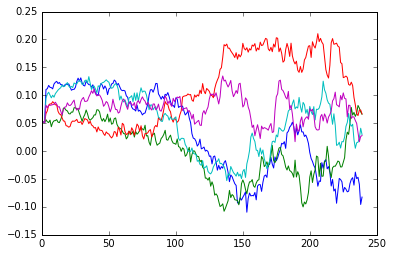

In [101]:
for i in range(num_sims):
    plt.plot(np.asarray(libor_rate_matrix[i,:])[0])
libor_rate_matrix

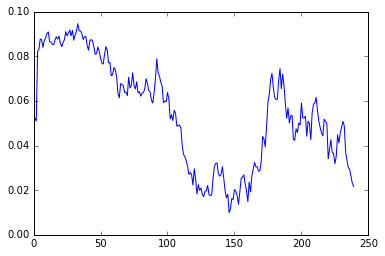

In [102]:
plt.plot(np.asarray(libor_rate_matrix.mean(0))[0])

In [103]:
def get_SMM_matrices(gamma, p, beta, libor_rate_matrix, num_sims):
    SMM_matrix_1 = []
    SMM_matrix_2 = []

    for i in range(num_sims):
        hazard_arr_1 = []
        hazard_arr_2 = []
        SMM_arr_1 = []
        SMM_arr_2 = []
        libor_arr = np.asarray(libor_rate_matrix[i,:])[0]

        SMM_matrix_1.append(pd.Series(SMM_func_arr(gamma, p, beta, 0, libor_arr)))
        SMM_matrix_2.append(pd.Series(SMM_func_arr(gamma, p, beta, 1, libor_arr)))
    return (SMM_matrix_1, SMM_matrix_2)

(SMM_matrix_1, SMM_matrix_2) = get_SMM_matrices(gamma, p, beta, libor_rate_matrix, num_sims)

# Qb

In [104]:
# basic information of two mortgage, for mortgage package
principal_1 = 77657656.75
monthly_interest_1 = 5.402/1200
payment_number_1 = 236
PSA_1 = 1.5
maturity_1 = 20
age_1 = 3

principal_2 = 128842343.35
monthly_interest_2 = 5.419/1200
payment_number_2 = 237
PSA_2 = 1.5
maturity_2 = 20
age_2 = 3

CG = 74800000
VE = 5200000
CM = 14000000
GZ = 22000000
TC = 20000000
CZ = 24000000
CA = 32550000
CY = 13950000
tranche_coupon = 5/(12*100)

In [105]:
#import imp
#m = imp.reload(m)

In [106]:
def get_p_and_se(num_sims, SMM_matrix_1, SMM_matrix_2):
    pricing_arr = []
    for i in range(num_sims):
        print(i)
        SMM_arr_1 = SMM_matrix_1[i]
        SMM_arr_2 = SMM_matrix_2[i]
        pool_CF_1 = m.pool_CF(principal_1, monthly_interest_1, payment_number_1, PSA_1, maturity_1, age_1, SMM_arr_1)
        pool_CF_2 = m.pool_CF(principal_2, monthly_interest_2, payment_number_2, PSA_2, maturity_2, age_2, SMM_arr_2)
        summary_CF = m.summary_CF(pool_CF_1, pool_CF_2)
        principal_CF_Alloc = m.Principal_CF_Alloc(summary_CF,tranche_coupon,CG,VE,CM,GZ,TC,CZ,CA,CY)
        principal = m.Principal(principal_CF_Alloc)
        balance = m.Balance(summary_CF,principal_CF_Alloc)
        interest = m.Interest(balance,principal_CF_Alloc,summary_CF,tranche_coupon)
        pricing = m.Pricing(principal,interest)
        pricing_arr.append(pricing)

    bond_prices_matrix = []
    standard_errors_matrix = []
    for i in range(num_sims):
        pricing = pricing_arr[i]
        # Adjsut the order of column 
        cols = pricing.columns.tolist()
        cols = [cols[6], cols[1], cols[8], cols[2], cols[5], cols[7], cols[4], cols[0], cols[3]]
        data_cashflow = pricing[cols]

        # Price bonds
        bonds = data_cashflow.iloc[:,1:]
        # bond_prices = 0.5 * ((cum_df_matrix[i] * np.matrix(bonds)) + (cum_df_anti_matrix[i] * np.matrix(bonds)))
        bond_prices = cum_df_matrix[i] * np.matrix(bonds)
        bond_prices = np.asarray(bond_prices)[0]
        bond_prices = [float('%.3f' % x) for x in bond_prices]


        bond_prices_matrix.append(bond_prices)
    bond_prices_matrix = np.matrix(bond_prices_matrix)
    bond_prices = np.asarray(bond_prices_matrix.mean(0))[0]
    standard_errors = np.asarray(bond_prices_matrix.std(0))[0]
    print(bond_prices)
    print(standard_errors)
    return (bond_prices, standard_errors)

get_p_and_se(num_sims, SMM_matrix_1, SMM_matrix_2)

0
1
2
3
4
[ 76490902.40540001   5344715.5376      14471813.1696      22952122.085
  21035945.9676      25948282.6176      33459531.776       14855067.3044    ]
[  826099.93914081    82265.35864421   290581.89832975   638115.58221783
   728796.83481132  1697970.41116566   507477.49199849   724359.19683696]


(array([ 76490902.40540001,   5344715.5376    ,  14471813.1696    ,
         22952122.085     ,  21035945.9676    ,  25948282.6176    ,
         33459531.776     ,  14855067.3044    ]),
 array([  826099.93914081,    82265.35864421,   290581.89832975,
          638115.58221783,   728796.83481132,  1697970.41116566,
          507477.49199849,   724359.19683696]))

# Residual

### V0

In [29]:
resid_tranche = summary_CF['Total_Interest'] + summary_CF['Total_Principal']
residual_cashflow = []

for r in r_matrix:
    residual_cashflow.append(r * resid_tranche/24)
residual_cashflow = np.matrix(residual_cashflow)

residual_arr = []
for d in cum_df_matrix:
    residual_arr.append(np.dot(residual_cashflow,np.matrix(d).T))
res_V0 = np.mean(residual_arr)
res_std = np.std(residual_arr) / math.sqrt(num_sims)

### V+ and V-

In [30]:
# Calculate V+ and V-
(cum_df_matrix_p, cum_df_anti_matrix_p, r_matrix_p, r_anti_matrix_p) = HW.Monte_Carlo_2(kappa, sigma, r0+dr, T, dt, coeff, num_sims)
(cum_df_matrix_m, cum_df_anti_matrix_m, r_matrix_m, r_anti_matrix_m) = HW.Monte_Carlo_2(kappa, sigma, r0-dr, T, dt, coeff, num_sims)

# V+
residual_cashflow = []
for r in r_matrix_p:
    residual_cashflow.append(r * resid_tranche/24)
residual_cashflow = np.matrix(residual_cashflow)

residual_arr = []
for d in cum_df_matrix_p:
    residual_arr.append(np.dot(residual_cashflow,np.matrix(d).T))
res_V_plus = np.mean(residual_arr)

# V-
residual_cashflow = []
for r in r_matrix_m:
    residual_cashflow.append(r * resid_tranche/24)
residual_cashflow = np.matrix(residual_cashflow)

residual_arr = []
for d in cum_df_matrix_m:
    residual_arr.append(np.dot(residual_cashflow,np.matrix(d).T))
res_V_minus = np.mean(residual_arr)

# Residual Duration

In [31]:
res_dur = HW.Effective_Duration(res_V0, res_V_plus, res_V_minus, dr)

# Residual Convexity

In [32]:
res_conv = HW.Effective_Convexity(res_V0, res_V_plus, res_V_minus, dr)

# Cash Flows for all 8 bonds

In [33]:
data_cashflow.head()

,Period,CG,VE,CM,GZ,TC,CZ,CA,CY
1,1.0,9.033040e+05,113333.333333,58333.333333,0.0,83333.333333,0.0,2.785071e+05,58125.0
2,2.0,1.198019e+06,113333.333333,58333.333333,0.0,83333.333333,0.0,3.641587e+05,58125.0
3,3.0,1.646742e+06,113333.333333,58333.333333,0.0,83333.333333,0.0,4.945689e+05,58125.0
4,4.0,2.940639e+06,113333.333333,58333.333333,0.0,83333.333333,0.0,8.706077e+05,58125.0
5,5.0,3.781112e+06,113333.333333,58333.333333,0.0,83333.333333,0.0,1.114870e+06,58125.0


# Price of Bonds, Duration and Convexity

In [34]:
# Calculate V+ and V-
(cum_df_matrix_p, cum_df_anti_matrix_p, r_matrix_p, r_anti_matrix_p) = HW.Monte_Carlo_2(kappa, sigma, r0+dr, T, dt, coeff, num_sims)
(cum_df_matrix_m, cum_df_anti_matrix_m, r_matrix_m, r_anti_matrix_m) = HW.Monte_Carlo_2(kappa, sigma, r0-dr, T, dt, coeff, num_sims)

bond_price_matrix_p = 0.5 * ((cum_df_matrix_p * np.matrix(bonds)) + (cum_df_anti_matrix_p * np.matrix(bonds)))
bond_prices_p = bond_price_matrix_p.mean(0).tolist()[0]
bond_prices_p = [float('%.3f' % x) for x in bond_prices_p]

bond_price_matrix_m = 0.5 * ((cum_df_matrix_m * np.matrix(bonds)) + (cum_df_anti_matrix_m * np.matrix(bonds)))
bond_prices_m = bond_price_matrix_m.mean(0).tolist()[0]
bond_prices_m = [float('%.3f' % x) for x in bond_prices_m]

# Calculate effective duration
eff_durs = HW.Effective_Duration(bond_prices, bond_prices_p, bond_prices_m, dr)
eff_durs = [float('%.3f' % x) for x in eff_durs]

# Calculate effective convexity
eff_conv = HW.Effective_Convexity(bond_prices, bond_prices_p, bond_prices_m, dr)
eff_conv = [float('%.3f' % x) for x in eff_conv]

par_price = np.array((CG,VE,CM,GZ,TC,CZ,CA,CY))

def oas_obj_func(oas,bond,i):
    dt = 1/12
    iterations = 240
    r_matrix_new = r_matrix + oas
    df_matrix_new = np.exp(-r_matrix_new*dt)
    cum_df_matrix_new = np.zeros((num_sims, iterations))
    for j in range(num_sims):
        cum_df_matrix_new[j,:] = df_matrix_new[j,:].cumprod()
    #return (cum_df_matrix_new * (np.matrix(bond).T)).mean()
    return (((cum_df_matrix_new * (np.matrix(bond).T)).mean() - par_price[i])/1e7)**2 

oas_arr = []
for i in range(8):
    oas_res = sp.optimize.minimize(lambda oas: oas_obj_func(oas, bonds.iloc[:,i],i),0.01)
    oas_arr.append(oas_res.x[0])

# merge results into dataframe
df = pd.DataFrame([bond_prices, standard_errors, eff_durs, eff_conv, oas_arr],
columns=data_cashflow.columns[1:], 
index=['Bond Prices', 'Standard Errors', 'Effective Duration', 'Effective Convexity','OAS'])

### Add residual to final results

In [35]:
df['R'] = [res_V0, res_std, res_dur, res_conv, np.nan]

### The bond price

In [36]:
df

,CG,VE,CM,GZ,TC,CZ,CA,CY,R
Bond Prices,7.663557e+07,5.358330e+06,1.451004e+07,2.294843e+07,2.095859e+07,2.548817e+07,3.351446e+07,1.469998e+07,2.818838e+05
Standard Errors,1.333047e+05,8.065901e+03,3.272515e+04,1.063423e+05,1.181294e+05,1.113387e+05,7.647957e+04,6.804543e+04,7.740535e+04
Effective Duration,8.320000e-01,1.062000e+00,1.270000e+00,1.523000e+00,1.814000e+00,2.649000e+00,1.022000e+00,2.186000e+00,-2.331479e+01
Effective Convexity,8.284522e+04,1.914725e+05,1.895393e+05,2.014261e+05,6.003210e+05,7.466229e+05,1.165061e+05,6.509243e+05,2.473509e+07
OAS,2.452776e-02,2.327958e-02,2.272965e-02,2.223861e-02,2.220318e-02,1.764880e-02,2.356204e-02,1.934957e-02,NaN


# Q(c)

### Ouput results from matlab functions

In [37]:
gamma_non = 0.0048375
p_non = 1.31377
beta_1_non = 69.75265
beta_2_non = -0.4082

In [39]:

'''
hazard_arr_1_non = []
hazard_arr_2_non = []
SMM_arr_1_non = []
SMM_arr_2_non = []

for t in range(1,241):
    hazard_arr_1_non.append(hazard_func(t, gamma_non, p_non, beta_non, 0))
    hazard_arr_2.append(hazard_func(t, gamma_non, p_non, beta_non, 1))
    SMM_arr_1_non.append(SMM_func(t-1, t, gamma_non, p_non, beta_non, 0))
    SMM_arr_2_non.append(SMM_func(t-1, t, gamma_non, p_non, beta_non, 1))
    
SMM_arr_1_non = pd.Series(SMM_arr_1_non)
SMM_arr_2_non = pd.Series(SMM_arr_2_non)

'''


beta_non = np.array([beta_1_non, beta_2_non])

SMM_matrix_1_non = []
SMM_matrix_2_non = []

for i in range(num_sims):
    hazard_arr_1_non = []
    hazard_arr_2_non = []
    SMM_arr_1_non = []
    SMM_arr_2_non = []
    libor_arr = np.asarray(libor_rate_matrix[i,:])[0]
    SMM_matrix_1_non.append(pd.Series(SMM_func_arr(gamma_non, p_non, beta_non, 0, libor_arr)))
    SMM_matrix_2_non.append(pd.Series(SMM_func_arr(gamma_non, p_non, beta_non, 1, libor_arr)))


In [ ]:
'''
plt.plot(SMM_arr_1_non)
plt.plot(SMM_arr_2_non)
a_non = len(SMM_arr_1_non)
print(a_non)
print(len(SMM_arr_1_non))
'''

pricing_arr_non = []
for i in range(num_sims):
    print(i)
    SMM_arr_1_non = SMM_matrix_1_non[i]
    SMM_arr_2_non = SMM_matrix_2_non[i]
    pool_CF_1 = m.pool_CF(principal_1, monthly_interest_1, payment_number_1, PSA_1, maturity_1, age_1, SMM_arr_1_non)
    pool_CF_2 = m.pool_CF(principal_2, monthly_interest_2, payment_number_2, PSA_2, maturity_2, age_2, SMM_arr_2_non)
    summary_CF = m.summary_CF(pool_CF_1, pool_CF_2)
    principal_CF_Alloc = m.Principal_CF_Alloc(summary_CF,tranche_coupon,CG,VE,CM,GZ,TC,CZ,CA,CY)
    principal = m.Principal(principal_CF_Alloc)
    balance = m.Balance(summary_CF,principal_CF_Alloc)
    interest = m.Interest(balance,principal_CF_Alloc,summary_CF,tranche_coupon)
    pricing = m.Pricing(principal,interest)
    pricing_arr_non.append(pricing)

In [ ]:

'''
pool_CF_1 = m.pool_CF(principal_1, monthly_interest_1, payment_number_1, PSA_1, maturity_1, age_1, SMM_arr_1_non)
pool_CF_2 = m.pool_CF(principal_2, monthly_interest_2, payment_number_2, PSA_2, maturity_2, age_2, SMM_arr_2_non)
summary_CF = m.summary_CF(pool_CF_1, pool_CF_2)
principal_CF_Alloc = m.Principal_CF_Alloc(summary_CF,tranche_coupon,CG,VE,CM,GZ,TC,CZ,CA,CY)
principal = m.Principal(principal_CF_Alloc)
balance = m.Balance(summary_CF,principal_CF_Alloc)
interest = m.Interest(balance,principal_CF_Alloc,summary_CF,tranche_coupon)
pricing = m.Pricing(principal,interest)
'''

In [ ]:
# Adjsut the order of column 
cols = pricing.columns.tolist()
cols = cols[6:7] + cols[1:2] + cols[8:9] + cols[2:3] + cols[5:6] + cols[7:8] + cols[4:5] + cols[0:1] + cols[3:4]
data_cashflow = pricing[cols]
data_cashflow.head()

In [ ]:
# 5,000 simulation, so that the total number of paths is 10,000
num_sims = 1000
T = 20
dt = 1.0/12.0
dr = 10e-5  # dr taken to be arbitrarily small
## Simlation:
## cum_df_matrix = cumulative discount factor matrix
## cum_df_anti_matrix = cumulative discount factor matrix with antithetic path
(cum_df_matrix, cum_df_anti_matrix, r_matrix, r_anti_matrix) = HW.Monte_Carlo_2(kappa, sigma, r0, K, T, dt, coeff, num_sims)


# Price bonds
bonds = data_cashflow.iloc[:,1:]
bond_price_matrix = 0.5 * ((cum_df_matrix * np.matrix(bonds)) + (cum_df_anti_matrix * np.matrix(bonds)))
bond_prices = bond_price_matrix.mean(0).tolist()[0]
bond_prices = [float('%.3f' % x) for x in bond_prices]

# Get standard errors of bonds
standard_errors = HW.Std_Err(bond_price_matrix, num_sims)

### V+ and V-

In [ ]:
# Calculate V+ and V-
(cum_df_matrix_p, cum_df_anti_matrix_p, r_matrix_p, r_anti_matrix_p) = HW.Monte_Carlo_2(kappa, sigma, r0+dr, K, T, dt, coeff, num_sims)
(cum_df_matrix_m, cum_df_anti_matrix_m, r_matrix_m, r_anti_matrix_m) = HW.Monte_Carlo_2(kappa, sigma, r0-dr, K, T, dt, coeff, num_sims)

# V+
residual_cashflow = []
for r in r_matrix_p:
    residual_cashflow.append(r * resid_tranche/24)
residual_cashflow = np.matrix(residual_cashflow)

residual_arr = []
for d in cum_df_matrix_p:
    residual_arr.append(np.dot(residual_cashflow,np.matrix(d).T))
res_V_plus = np.mean(residual_arr)

# V-
residual_cashflow = []
for r in r_matrix_m:
    residual_cashflow.append(r * resid_tranche/24)
residual_cashflow = np.matrix(residual_cashflow)

residual_arr = []
for d in cum_df_matrix_m:
    residual_arr.append(np.dot(residual_cashflow,np.matrix(d).T))
res_V_minus = np.mean(residual_arr)

### Residual Duration and Convexity

In [ ]:
res_dur = HW.Effective_Duration(res_V0, res_V_plus, res_V_minus, dr)
res_conv = HW.Effective_Convexity(res_V0, res_V_plus, res_V_minus, dr)

# Cash Flows for all 8 bonds
data_cashflow.head()

# Price of Bonds, Duration and Convexity



In [ ]:
# Calculate V+ and V-
(cum_df_matrix_p, cum_df_anti_matrix_p, r_matrix_p, r_anti_matrix_p) = HW.Monte_Carlo_2(kappa, sigma, r0+dr, K, T, dt, coeff, num_sims)
(cum_df_matrix_m, cum_df_anti_matrix_m, r_matrix_m, r_anti_matrix_m) = HW.Monte_Carlo_2(kappa, sigma, r0-dr, K, T, dt, coeff, num_sims)

bond_price_matrix_p = 0.5 * ((cum_df_matrix_p * np.matrix(bonds)) + (cum_df_anti_matrix_p * np.matrix(bonds)))
bond_prices_p = bond_price_matrix_p.mean(0).tolist()[0]
bond_prices_p = [float('%.3f' % x) for x in bond_prices_p]

bond_price_matrix_m = 0.5 * ((cum_df_matrix_m * np.matrix(bonds)) + (cum_df_anti_matrix_m * np.matrix(bonds)))
bond_prices_m = bond_price_matrix_m.mean(0).tolist()[0]
bond_prices_m = [float('%.3f' % x) for x in bond_prices_m]

# Calculate effective duration
eff_durs = HW.Effective_Duration(bond_prices, bond_prices_p, bond_prices_m, dr)
eff_durs = [float('%.3f' % x) for x in eff_durs]

# Calculate effective convexity
eff_conv = HW.Effective_Convexity(bond_prices, bond_prices_p, bond_prices_m, dr)
eff_conv = [float('%.3f' % x) for x in eff_conv]

par_price = np.array((CG,VE,CM,GZ,TC,CZ,CA,CY))

def oas_obj_func(oas,bond,i):
    dt = 1/12
    iterations = 240
    r_matrix_new = r_matrix + oas
    df_matrix_new = np.exp(-r_matrix_new*dt)
    cum_df_matrix_new = np.zeros((num_sims, iterations))
    for j in range(num_sims):
        cum_df_matrix_new[j,:] = df_matrix_new[j,:].cumprod()
    #return (cum_df_matrix_new * (np.matrix(bond).T)).mean()
    return (((cum_df_matrix_new * (np.matrix(bond).T)).mean() - par_price[i])/1e7)**2 

oas_arr = []
for i in range(8):
    oas_res = sp.optimize.minimize(lambda oas: oas_obj_func(oas, bonds.iloc[:,i],i),0.01)
    oas_arr.append(oas_res.x[0])

# merge results into dataframe
df = pd.DataFrame([bond_prices, standard_errors, eff_durs, eff_conv, oas_arr],
columns=data_cashflow.columns[1:], 
index=['Bond Prices', 'Standard Errors', 'Effective Duration', 'Effective Convexity','OAS'])

# Add residual to final result
df['R'] = [res_V0, res_std, res_dur, res_conv, np.nan]


In [ ]:
df